## Flights Agg analysis

First, let's start with the basics:


Setup:
- Single `m5.large` instance
- everything run single-threaded-
- C++ dummy code using csvmonkey parser
- run over full flight data (from 1987 - 2021).


We basically compare how fast 1. general-case code would run vs. 2. per-file specialized code.

The python query we're interested in is roughly:

```
c.csv('flights*.csv')
 .mapColumn('WEATHER_DELAY', lambda x: 0 if x is None else x)
 .selectColumns(['MONTH', 'DAY', 'WEATHER_DELAY'])
 .aggregateByKey(['MONTH', 'DAY'], ['mean', 'std'])
 .collect()

```

Each version is translated to asm using clang-9 with the following flags:

`-shared -fPIC -O3 -msse4.2 -mcx16 -march=native -DNDEBUG`


- general case C++ source: `../src/agg_query/agg_general.cc`
- specialized case C++ source: `../src/agg_query/agg_specialized.cc`
- benchmark script: `../benchmark-agg-m5.sh`

All files till 2003/05 can utilize the specialized version, all others require the general case version.

General case version:

```
extern "C" int64_t process_cells(void *userData, char **cells, int64_t *cell_sizes) {

    // only care about the WEATHER_DELAY cell, yet filter based on JFK airport code!
    auto s_day = cells[DAY_COLUMN_INDEX];
    auto s_month = cells[MONTH_COLUMN_INDEX];
    auto s_weather_delay = cells[WEATHER_DELAY_COLUMN_INDEX];
    auto s_airport_code = cells[AIRPORT_CODE_INDEX];

    //// parsing avoided here...
    //if(0 == strcmp(s_airport_code, "12478")) {
        // compute aggregate for current airport
        double weather_delay;

        if(0 == strlen(s_weather_delay))
            weather_delay = 0.0;
        else {
            // parse as float!
            weather_delay = atof(s_weather_delay);
        }

        // Note: could hash using string directly, i.e. delayed parsing?
        auto day = atoi(s_day);
        auto month = atoi(s_month);

        // put into aggregate
        int key = month + 16 * day;


        // using https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
        // # For a new value newValue, compute the new count, new mean, the new M2.
        //# mean accumulates the mean of the entire dataset
        //# M2 aggregates the squared distance from the mean
        //# count aggregates the number of samples seen so far
        //def update(existingAggregate, newValue):
        //    (count, mean, M2) = existingAggregate
        //    count += 1
        //    delta = newValue - mean
        //    mean += delta / count
        //    delta2 = newValue - mean
        //    M2 += delta * delta2
        //    return (count, mean, M2)

        // not in use? init!
        auto& entry = agg_map[key];
        if(!entry.in_use) {
            entry.in_use = true;
            entry.count = 0;
            entry.mean = 0.0;
            entry.m2 = 0.0;
        }

        auto count = agg_map[key].count;
        auto mean = agg_map[key].mean;
        auto m2 = agg_map[key].m2;

        count++;
        auto delta = weather_delay - mean;
        mean += delta / count;
        auto delta2 = weather_delay - mean;
        m2 += delta * delta2;
        agg_map[key].count = count;
        agg_map[key].mean = mean;
        agg_map[key].m2 = m2;
    //}

    return 0;
}
```


Resulting assembly (from m5.large):
```
00000000000013b0 <process_cells>:
    13b0:	41 56                	push   %r14
    13b2:	53                   	push   %rbx
    13b3:	50                   	push   %rax
    13b4:	4c 8b 76 10          	mov    0x10(%rsi),%r14
    13b8:	48 8b 5e 18          	mov    0x18(%rsi),%rbx
    13bc:	48 8b be c8 01 00 00 	mov    0x1c8(%rsi),%rdi
    13c3:	80 3f 00             	cmpb   $0x0,(%rdi)
    13c6:	74 09                	je     13d1 <process_cells+0x21>
    13c8:	31 f6                	xor    %esi,%esi
    13ca:	e8 a1 fc ff ff       	callq  1070 <strtod@plt>
    13cf:	eb 04                	jmp    13d5 <process_cells+0x25>
    13d1:	c5 f9 57 c0          	vxorpd %xmm0,%xmm0,%xmm0
    13d5:	c5 fb 11 04 24       	vmovsd %xmm0,(%rsp)
    13da:	48 89 df             	mov    %rbx,%rdi
    13dd:	31 f6                	xor    %esi,%esi
    13df:	ba 0a 00 00 00       	mov    $0xa,%edx
    13e4:	e8 d7 fc ff ff       	callq  10c0 <strtol@plt>
    13e9:	48 89 c3             	mov    %rax,%rbx
    13ec:	4c 89 f7             	mov    %r14,%rdi
    13ef:	31 f6                	xor    %esi,%esi
    13f1:	ba 0a 00 00 00       	mov    $0xa,%edx
    13f6:	e8 c5 fc ff ff       	callq  10c0 <strtol@plt>
    13fb:	c1 e3 04             	shl    $0x4,%ebx
    13fe:	01 c3                	add    %eax,%ebx
    1400:	48 8b 05 89 2c 00 00 	mov    0x2c89(%rip),%rax        # 4090 <_ZL7agg_map>
    1407:	48 63 cb             	movslq %ebx,%rcx
    140a:	48 c1 e1 05          	shl    $0x5,%rcx
    140e:	80 3c 08 00          	cmpb   $0x0,(%rax,%rcx,1)
    1412:	74 16                	je     142a <process_cells+0x7a>
    1414:	48 8b 54 08 08       	mov    0x8(%rax,%rcx,1),%rdx
    1419:	c5 fb 10 4c 08 10    	vmovsd 0x10(%rax,%rcx,1),%xmm1
    141f:	c5 fb 10 44 08 18    	vmovsd 0x18(%rax,%rcx,1),%xmm0
    1425:	48 ff c2             	inc    %rdx
    1428:	eb 27                	jmp    1451 <process_cells+0xa1>
    142a:	48 8d 14 08          	lea    (%rax,%rcx,1),%rdx
    142e:	c6 02 01             	movb   $0x1,(%rdx)
    1431:	c5 f9 57 c0          	vxorpd %xmm0,%xmm0,%xmm0
    1435:	c5 f9 11 44 08 08    	vmovupd %xmm0,0x8(%rax,%rcx,1)
    143b:	48 c7 44 08 18 00 00 	movq   $0x0,0x18(%rax,%rcx,1)
    1442:	00 00 
    1444:	ba 01 00 00 00       	mov    $0x1,%edx
    1449:	c5 f9 57 c0          	vxorpd %xmm0,%xmm0,%xmm0
    144d:	c5 f1 57 c9          	vxorpd %xmm1,%xmm1,%xmm1
    1451:	c4 e1 eb 2a d2       	vcvtsi2sd %rdx,%xmm2,%xmm2
    1456:	c5 fb 10 24 24       	vmovsd (%rsp),%xmm4
    145b:	c5 db 5c d9          	vsubsd %xmm1,%xmm4,%xmm3
    145f:	c5 e3 5e d2          	vdivsd %xmm2,%xmm3,%xmm2
    1463:	c5 f3 58 ca          	vaddsd %xmm2,%xmm1,%xmm1
    1467:	c5 db 5c d1          	vsubsd %xmm1,%xmm4,%xmm2
    146b:	c5 e3 59 d2          	vmulsd %xmm2,%xmm3,%xmm2
    146f:	c5 fb 58 c2          	vaddsd %xmm2,%xmm0,%xmm0
    1473:	48 89 54 08 08       	mov    %rdx,0x8(%rax,%rcx,1)
    1478:	c5 fb 11 4c 08 10    	vmovsd %xmm1,0x10(%rax,%rcx,1)
    147e:	c5 fb 11 44 08 18    	vmovsd %xmm0,0x18(%rax,%rcx,1)
    1484:	31 c0                	xor    %eax,%eax
    1486:	48 83 c4 08          	add    $0x8,%rsp
    148a:	5b                   	pop    %rbx
    148b:	41 5e                	pop    %r14
    148d:	c3                   	retq   
    148e:	66 90                	xchg   %ax,%ax
```

Specialized case version:

```
extern "C" int64_t process_cells(void *userData, char **cells, int64_t *cell_sizes) {

    // only care about the WEATHER_DELAY cell, yet filter based on JFK airport code!
    auto s_day = cells[DAY_COLUMN_INDEX];
    auto s_month = cells[MONTH_COLUMN_INDEX];
    auto s_weather_delay = cells[WEATHER_DELAY_COLUMN_INDEX];
    auto s_airport_code = cells[AIRPORT_CODE_INDEX];

    // parsing avoided here...
    //if(0 == strcmp(s_airport_code, "12478")) {

        // compute aggregate for current airport
        double weather_delay;

        if(0 != strlen(s_weather_delay))
            return SPECIALIZATION_FAILURE;

        // Note: could hash using string directly, i.e. delayed parsing?
        auto day = atoi(s_day);
        auto month = atoi(s_month);

        // put into aggregate
        int key = month + 16 * day;

        // using https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
        // # For a new value newValue, compute the new count, new mean, the new M2.
        //# mean accumulates the mean of the entire dataset
        //# M2 aggregates the squared distance from the mean
        //# count aggregates the number of samples seen so far
        //def update(existingAggregate, newValue):
        //    (count, mean, M2) = existingAggregate
        //    count += 1
        //    delta = newValue - mean
        //    mean += delta / count
        //    delta2 = newValue - mean
        //    M2 += delta * delta2
        //    return (count, mean, M2)

        // not in use? init!
        auto& entry = agg_map[key];
        if(!entry.in_use) {
            entry.in_use = true;
            entry.count = 0;
        } else {
            entry.count++; // this is NOT the actual count, but rather a count of how many constant inputs were encountered...
        }
   // }

    return 0;
}
```


Resulting assembly (from m5.large):
```
0000000000001410 <process_cells>:
    1410:	41 56                	push   %r14
    1412:	53                   	push   %rbx
    1413:	50                   	push   %rax
    1414:	48 8b 8e c8 01 00 00 	mov    0x1c8(%rsi),%rcx
    141b:	b8 2a 00 00 00       	mov    $0x2a,%eax
    1420:	80 39 00             	cmpb   $0x0,(%rcx)
    1423:	74 08                	je     142d <process_cells+0x1d>
    1425:	48 83 c4 08          	add    $0x8,%rsp
    1429:	5b                   	pop    %rbx
    142a:	41 5e                	pop    %r14
    142c:	c3                   	retq   
    142d:	4c 8b 76 10          	mov    0x10(%rsi),%r14
    1431:	48 8b 7e 18          	mov    0x18(%rsi),%rdi
    1435:	31 f6                	xor    %esi,%esi
    1437:	ba 0a 00 00 00       	mov    $0xa,%edx
    143c:	e8 cf fc ff ff       	callq  1110 <strtol@plt>
    1441:	48 89 c3             	mov    %rax,%rbx
    1444:	4c 89 f7             	mov    %r14,%rdi
    1447:	31 f6                	xor    %esi,%esi
    1449:	ba 0a 00 00 00       	mov    $0xa,%edx
    144e:	e8 bd fc ff ff       	callq  1110 <strtol@plt>
    1453:	c1 e3 04             	shl    $0x4,%ebx
    1456:	01 c3                	add    %eax,%ebx
    1458:	48 8b 05 61 2c 00 00 	mov    0x2c61(%rip),%rax        # 40c0 <_ZL7agg_map>
    145f:	48 63 cb             	movslq %ebx,%rcx
    1462:	48 c1 e1 05          	shl    $0x5,%rcx
    1466:	80 3c 08 00          	cmpb   $0x0,(%rax,%rcx,1)
    146a:	74 07                	je     1473 <process_cells+0x63>
    146c:	48 ff 44 08 08       	incq   0x8(%rax,%rcx,1)
    1471:	eb 10                	jmp    1483 <process_cells+0x73>
    1473:	48 8d 14 08          	lea    (%rax,%rcx,1),%rdx
    1477:	c6 02 01             	movb   $0x1,(%rdx)
    147a:	48 c7 44 08 08 00 00 	movq   $0x0,0x8(%rax,%rcx,1)
    1481:	00 00 
    1483:	31 c0                	xor    %eax,%eax
    1485:	48 83 c4 08          	add    $0x8,%rsp
    1489:	5b                   	pop    %rbx
    148a:	41 5e                	pop    %r14
    148c:	c3                   	retq   
    148d:	0f 1f 00             	nopl   (%rax)
```

So let's crunch the numbers.

THESE SHOWN HERE ARE WITH PRELOADING THE CSV TO MEMORY FIRST.

In [1]:
!tar xf results-agg-experiment.tar.gz

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import glob
import os
import json

In [3]:
logs_path = './results-agg-experiment/logs'
paths = glob.glob(os.path.join(logs_path, '*.txt'))

In [4]:
rows = []
for path in paths:
    try:
        name = os.path.basename(path)
        t = name[:name.find('-run')].replace('flights-', '')
        r = int(name[name.find('run-')+4:name.rfind('-date')])

        yearmonth = int(name[name.find('date-')+5:].replace('.txt', ''))
        year = yearmonth // 100
        month = yearmonth % 100
        row = {'type' : t, 'run' : r, 'year' : int(year), 'month' : int(month)}

        with open(path, 'r') as fp:
            lines = fp.readlines()

        row.update({'t_' + k : v for k, v in json.loads(lines[-1]).items()})
        rows.append(row)
    except Exception as e:
        print('ERROR: {}'.format(path))
df = pd.DataFrame(rows)

ERROR: ./results-agg-experiment/logs/flights-specialized-run-3-date-201001.txt
ERROR: ./results-agg-experiment/logs/flights-general-run-2-date-201001.txt
ERROR: ./results-agg-experiment/logs/flights-general-run-3-date-201001.txt
ERROR: ./results-agg-experiment/logs/flights-specialized-run-2-date-201001.txt
ERROR: ./results-agg-experiment/logs/flights-general-run-1-date-201001.txt
ERROR: ./results-agg-experiment/logs/flights-specialized-run-1-date-201001.txt


In [5]:
# drop the first run, important because it's loading the file from EBS to RAM
df = df[df['run'] != 1]

In [6]:
gdf = df.groupby(['type', 'year', 'month']).mean().reset_index()
gdf = gdf.sort_values(by=['year', 'month', 'type']).reset_index(drop=True)
gdf.head()

,type,year,month,run,t_output,t_preload,t_transform,t_total
0,general,1987,10,2.5,0.001340,2.979575,0.107623,3.088535
1,specialized,1987,10,2.5,0.001300,2.992310,0.109388,3.102995
2,general,1987,11,2.5,0.001307,2.811200,0.101381,2.913890
3,specialized,1987,11,2.5,0.001333,2.821045,0.103637,2.926015
4,general,1987,12,2.5,0.001331,2.920800,0.104750,3.026880


In [7]:
len(gdf)

818

(0.0, 200.0)

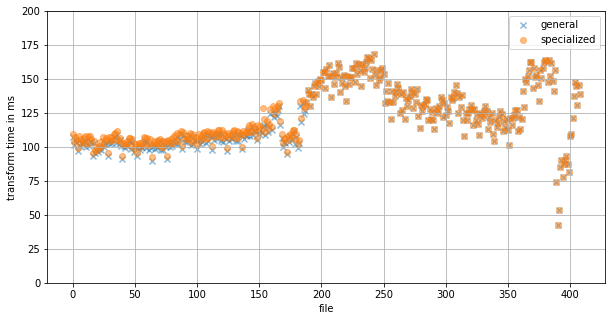

In [8]:
gdf_general = gdf.iloc[::2]
gdf_special = gdf.iloc[1::2]

plt.figure(figsize=(10, 5))
plt.grid()
plt.ylabel('transform time in ms')
plt.xlabel('file')
plt.scatter(np.arange(len(gdf_general)), gdf_general['t_transform'] * 1000, marker='x', alpha=.5, label='general')
plt.scatter(np.arange(len(gdf_special)), gdf_special['t_transform'] * 1000, marker='o', alpha=.5, label='specialized')
plt.legend(loc='best')

plt.ylim(0, 200)

to understand a bit better what's going, let's also plot here the file sizes:

Text(0.5, 0, 'file')

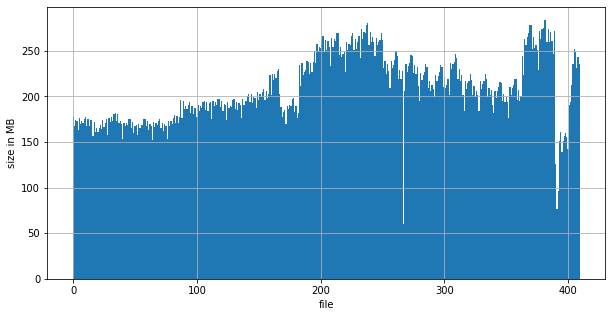

In [9]:
with open('flight_data_sizes.tsv', 'r') as fp:
    lines = filter(lambda line: len(line.strip()) > 0, fp.readlines())
lines = list(map(lambda parts: (int(parts[4]), parts[-1].strip()),
             map(lambda line: [x for x in line.split(' ') if len(x) > 0], lines)))

sizes = np.array([info[0] for info in lines])
sizes_in_mb = sizes / 1024 / 1024

plt.figure(figsize=(10, 5))
plt.grid()
plt.bar(np.arange(len(sizes_in_mb)), sizes_in_mb, width=1.)
plt.ylabel('size in MB')
plt.xlabel('file')

Looking at the numbers there's basically no significant difference.

(note: for time reasons above numbers are averages of 2 runs only)

In [10]:
gdf_general.sum()['t_transform'], gdf_special.sum()['t_transform']

(49.57749235, 50.06845855)

---
(c) 2017 - 2022 Tuplex authors